<a href="https://colab.research.google.com/github/SammyGbabs/Maize_Classification-Model/blob/main/Maize_classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset


Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 93% 149M/161M [00:01<00:00, 142MB/s]
100% 161M/161M [00:01<00:00, 144MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/corn-or-maize-leaf-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [ ]:
#Defining the directory path for the dataset
path = '/content/data'

#Getting and loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [ ]:
#Getting the class names
classes = dataset.class_names
classes

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
#The length of the dataset
len(dataset)

131

In [ ]:
#A batch of 32 and each image has size of 256 * 256 pixels
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 3 1 0 0 3 3 2 1 2 3 1 1 2 3 1 3 0 2 0 0 1 0 3 3 3 2 2 1 1 0 0]


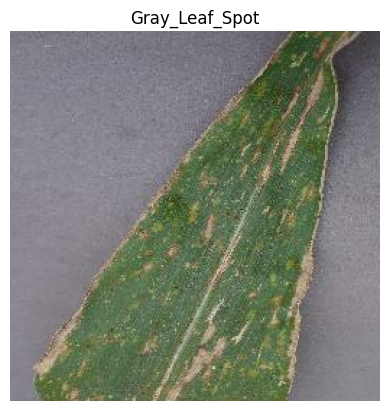

In [ ]:
#Viewing one of the images
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

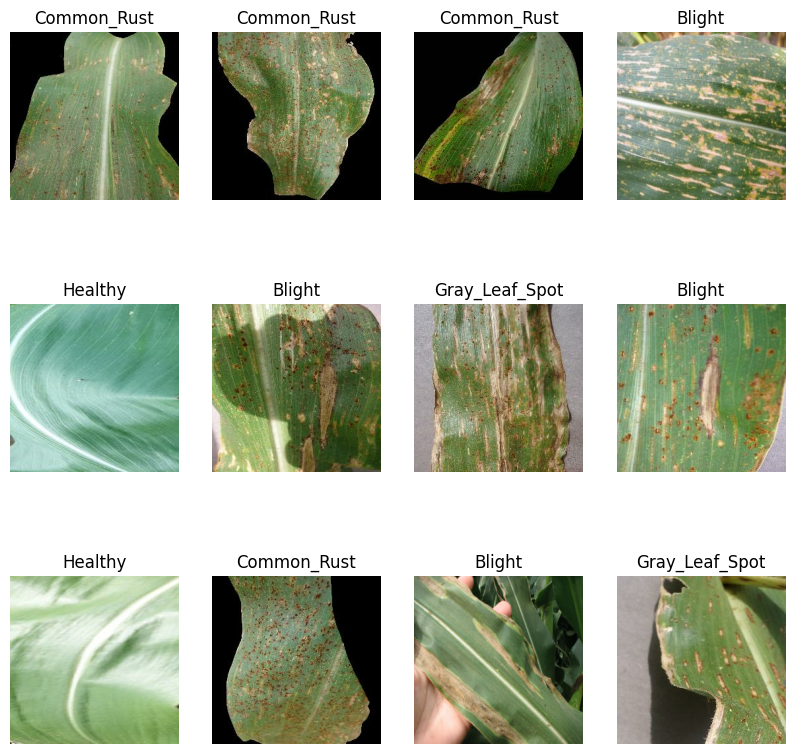

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

In [ ]:
#Getting the train size for the dataset
train_size = 0.7
len(dataset) * train_size

91.69999999999999

In [ ]:
#Defining a function to split the dataset in tf
def splitting_dataset_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = splitting_dataset_tf(dataset)


In [ ]:
len(train_ds)

91

In [ ]:
len(val_ds)

19

In [ ]:
len(test_ds)

21

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Scaling the dataset
scaling = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
#Using data augmentation for better performance
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# **TRAINING THE VANILLA MODEL**

In [ ]:
# Define input shape before creating the Sequential model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Create the Sequential model and specify the input shape in the first layer
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape[1:]),  # Input layer with shape (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    scaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - accuracy: 0.4066 - loss: 1.2052 - val_accuracy: 0.7188 - val_loss: 0.8428
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 422s 5s/step - accuracy: 0.6060 - loss: 0.8669 - val_accuracy: 0.7582 - val_loss: 0.5645
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 427s 5s/step - accuracy: 0.7575 - loss: 0.6416 - val_accuracy: 0.7664 - val_loss: 0.5091
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.8114 - loss: 0.4997 - val_accuracy: 0.8339 - val_loss: 0.4367
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.8200 - loss: 0.4677 - val_accuracy: 0.8257 - val_loss: 0.4052
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.8244 - loss: 0.4379 - val_accuracy: 0.8405 - val_loss: 0.3403
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 441s 5s/step - accuracy: 0.8301 - loss: 0.4117 - val_accuracy: 0.5822 - val_loss: 1.8757
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 421s 5s/step - accuracy: 0.8297 - loss: 0.4448 - val_accuracy: 0.8651 - v

In [ ]:
test_perf = model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8643 - loss: 0.3730


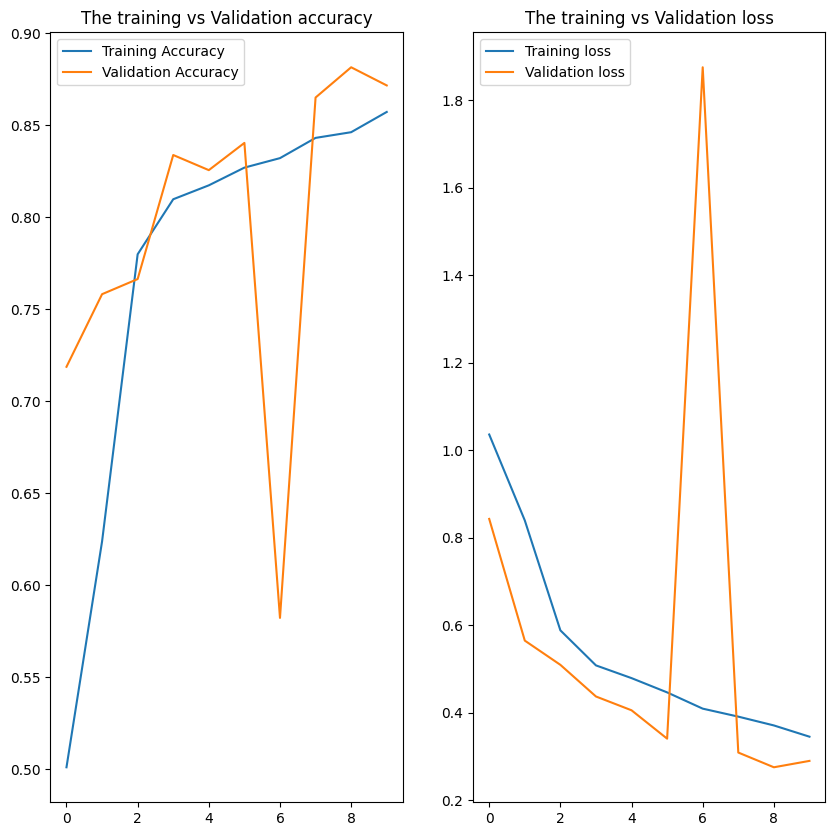

In [ ]:
#Doing a plot to visualize the output

accu = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(10), accu, label='Training Accuracy')
plt.plot(range(10), val_accu, label='Validation Accuracy')
plt.legend()
plt.title('The training vs Validation accuracy');

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training loss')
plt.plot(range(10), val_loss, label='Validation loss')
plt.legend()
plt.title('The training vs Validation loss');

First image to predict:
Actual label on dataset: Gray_Leaf_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted label by model: Gray_Leaf_Spot


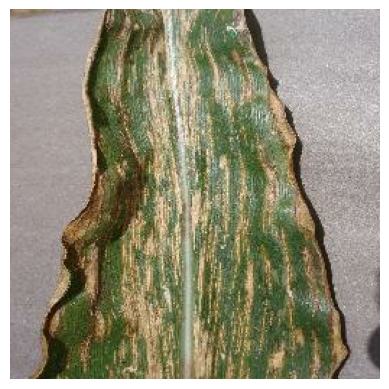

In [ ]:
#Making a prediction
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  img_1 = images_batch[0].numpy().astype('uint8')
  img1_label = labels_batch[0].numpy()

  print('First image to predict:')
  plt.imshow(img_1)
  print('Actual label on dataset:', classes[img1_label])

  batch_prediction = model.predict(images_batch)
  print('Predicted label by model:', classes[np.argmax(batch_prediction[0])])
  plt.axis("off")

In [ ]:
#Doing more predictions
def predict(model1, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model1.predict(img_array)

  predicted_class = classes[np.argmax(predictions[0])]
  confidence_level = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence_level

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


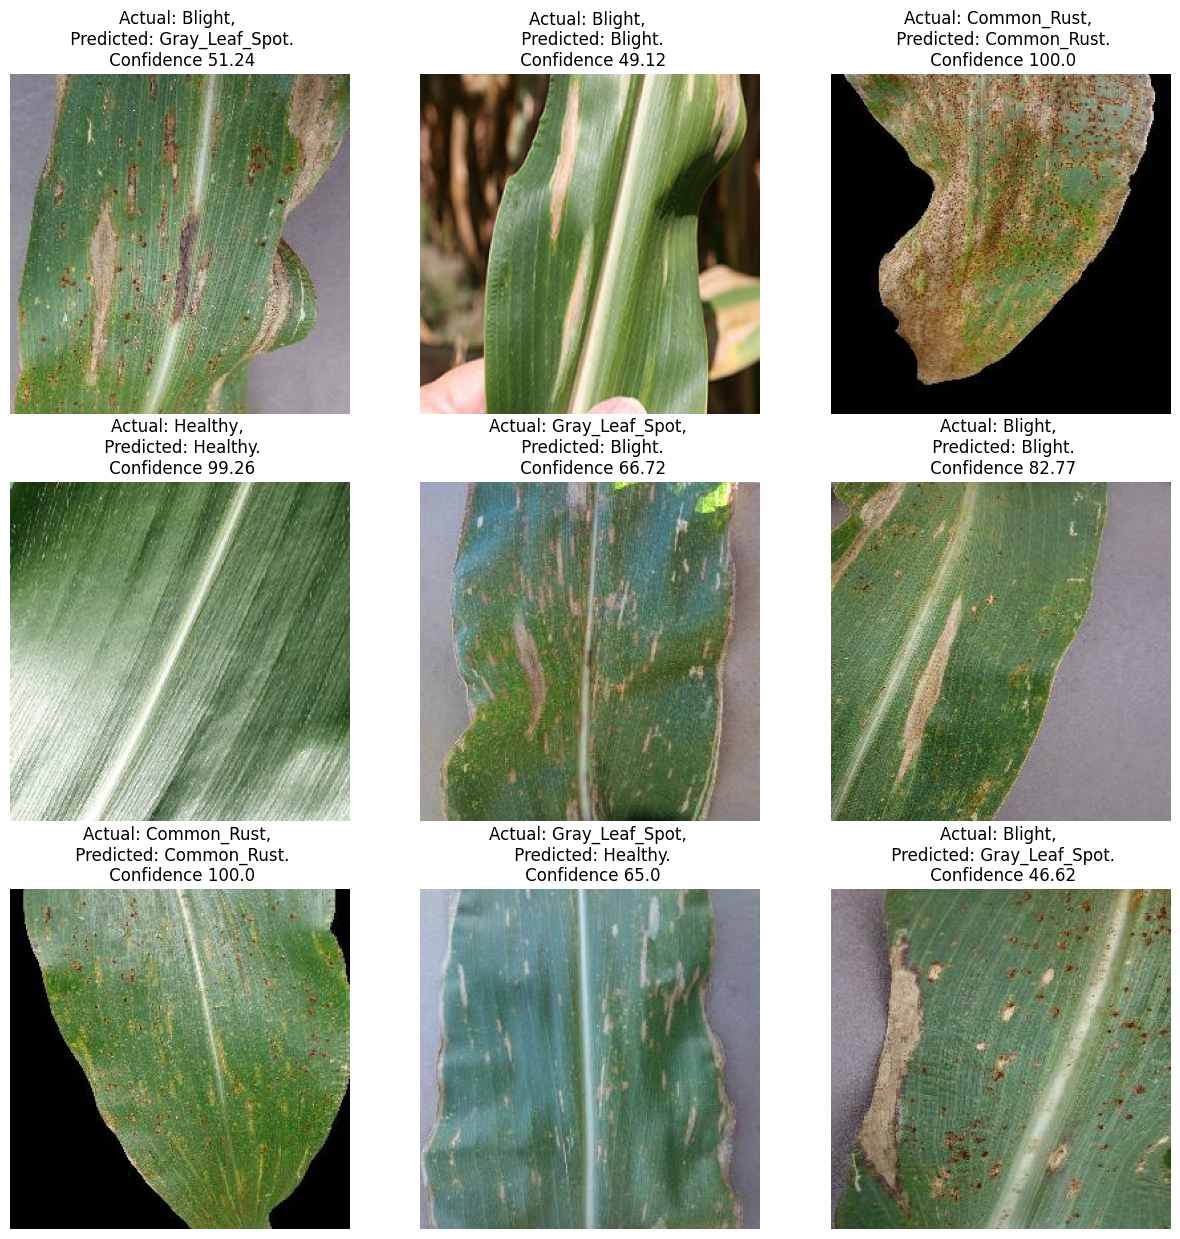

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence_level = predict(model, images[i].numpy())
    actual_class = classes[labels[i]]

    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence {confidence_level}')
    plt.axis("off")

In [ ]:
from keras.regularizers import l1
# Assuming BATCH_SIZE, IMAGE_SIZE, and CHANNELS are defined elsewhere
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Remove BATCH_SIZE from input_shape

model1 = models.Sequential([
    scaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l1(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model1.fit(
    train_ds,
    epochs=15,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - accuracy: 0.4362 - loss: 1.2005 - val_accuracy: 0.7961 - val_loss: 0.7573
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 427s 5s/step - accuracy: 0.8142 - loss: 0.5600 - val_accuracy: 0.8273 - val_loss: 0.4431
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 429s 5s/step - accuracy: 0.8222 - loss: 0.4581 - val_accuracy: 0.7928 - val_loss: 0.6429
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 441s 5s/step - accuracy: 0.8164 - loss: 0.4765 - val_accuracy: 0.8289 - val_loss: 0.4282
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 429s 5s/step - accuracy: 0.8505 - loss: 0.4088 - val_accuracy: 0.7681 - val_loss: 0.5994
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.8274 - loss: 0.4483 - val_accuracy: 0.8174 - val_loss: 0.4987
Epoch 7/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 428s 5s/step - accuracy: 0.8521 - loss: 0.3961 - val_accuracy: 0.8372 - val_loss: 0.4043
Epoch 8/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.8645 - loss: 0.3717 - val_accuracy: 0.8635 - v

In [1]:
test_perf = model1.evaluate(test_ds)

NameError: name 'model1' is not defined